In [1]:
!pip install numpy pandas opencv-python matplotlib scikit-learn xgboost nibabel flask

   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   -----------------

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ~~~~~~~~~~~~~^^^^^
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ~~~~~~~~~~~~~^^^^^
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
                  ~~~~~~~~~~~~~~^^^^^
  File "C:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\http\client.py", line 479, in read
    s = self.fp.read

In [2]:
import os
import glob
import random
import numpy as np
import nibabel as nib
import cv2
import xgboost as xgb
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
import pickle
import time


In [ ]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
import os
import tarfile

TAR_FILE = '/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar'

EXTRACT_PATH = '/kaggle/working/data'

os.makedirs(EXTRACT_PATH, exist_ok=True)

with tarfile.open(TAR_FILE, 'r') as tar:
    tar.extractall(path=EXTRACT_PATH)

print("Dataset extracted to:", EXTRACT_PATH)


Dataset extracted to: /kaggle/working/data


In [ ]:
import os
import numpy as np
import nibabel as nib

def load_subject_data(subject_folder):
    subject_id = os.path.basename(subject_folder)
    flair_path = os.path.join(subject_folder, f"{subject_id}_flair.nii.gz")
    t1_path    = os.path.join(subject_folder, f"{subject_id}_t1.nii.gz")
    t1ce_path  = os.path.join(subject_folder, f"{subject_id}_t1ce.nii.gz")
    t2_path    = os.path.join(subject_folder, f"{subject_id}_t2.nii.gz")
    seg_path   = os.path.join(subject_folder, f"{subject_id}_seg.nii.gz")

    flair = nib.load(flair_path, mmap=True).get_fdata(dtype=np.float32)
    t1    = nib.load(t1_path, mmap=True).get_fdata(dtype=np.float32)
    t1ce  = nib.load(t1ce_path, mmap=True).get_fdata(dtype=np.float32)
    t2    = nib.load(t2_path, mmap=True).get_fdata(dtype=np.float32)
    seg   = nib.load(seg_path, mmap=True).get_fdata(dtype=np.float32)

    multi_modal = np.stack([flair, t1, t1ce, t2], axis=0)
    return multi_modal, seg

def extract_slice_features(volume, seg):
    num_modal, H, W, D = volume.shape
    features = []
    labels = []
    for d in range(D):
        slice_modal = volume[:, :, :, d]
        means = slice_modal.reshape(num_modal, -1).mean(axis=1)
        stds  = slice_modal.reshape(num_modal, -1).std(axis=1)
        feat = np.concatenate([means, stds])
        features.append(feat)

        seg_slice = seg[:, :, d]
        label = 1 if np.any(seg_slice > 0) else 0
        labels.append(label)
    return features, labels

data_root = "/kaggle/working/data"
all_features = []
all_labels = []

for subject in os.listdir(data_root):
    subject_folder = os.path.join(data_root, subject)
    if os.path.isdir(subject_folder):
        print(f"Processing: {subject}")
        try:
            volume, seg = load_subject_data(subject_folder)
            features, labels = extract_slice_features(volume, seg)
            all_features.extend(features)
            all_labels.extend(labels)
        except Exception as e:
            print(f"Error processing {subject}: {e}")

print(f"Total slices processed: {len(all_features)}")
print(f"Sample feature vector: {all_features[0]}")
print(f"Sample label: {all_labels[0]}")


Processing: BraTS2021_01017
Processing: BraTS2021_01314
Processing: BraTS2021_01579
Processing: BraTS2021_01452
Processing: BraTS2021_01258
Processing: BraTS2021_00242
Processing: BraTS2021_00416
Processing: BraTS2021_01512
Processing: BraTS2021_01483
Processing: BraTS2021_01611
Processing: BraTS2021_01078
Processing: BraTS2021_01619
Processing: BraTS2021_01426
Processing: BraTS2021_01357
Processing: BraTS2021_00285
Processing: BraTS2021_01030
Processing: BraTS2021_00571
Processing: BraTS2021_01015
Processing: BraTS2021_00618
Processing: BraTS2021_00371
Processing: BraTS2021_01392
Processing: BraTS2021_00070
Processing: BraTS2021_00176
Processing: BraTS2021_01276
Processing: BraTS2021_00764
Processing: BraTS2021_00395
Processing: BraTS2021_00236
Processing: BraTS2021_01642
Processing: BraTS2021_01097
Processing: BraTS2021_00799
Processing: BraTS2021_01098
Processing: BraTS2021_01208
Processing: BraTS2021_01249
Processing: BraTS2021_00840
Processing: BraTS2021_01501
Processing: BraTS202

In [ ]:
import xgboost as xgb
import random
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

class RedDeerOptimization:
    def __init__(self, num_deer=10, max_iter=5, lr_bounds=(0.01, 0.3), depth_bounds=(3, 10)):
        self.num_deer = num_deer
        self.max_iter = max_iter
        self.lr_bounds = lr_bounds
        self.depth_bounds = depth_bounds

    def objective_function(self, lr, max_depth, X_train, y_train, X_val, y_val):
        params = {
            'objective': 'binary:logistic',
            'learning_rate': lr,
            'max_depth': int(max_depth),
            'eval_metric': 'logloss',
            'seed': 42,
            'verbosity': 0
        }
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        model = xgb.train(params, dtrain, num_boost_round=30, evals=[(dval, 'eval')], verbose_eval=False)
        preds = model.predict(dval)
        preds_binary = (preds > 0.5).astype(int)
        error = 1 - accuracy_score(y_val, preds_binary)
        return error

    def optimize(self, X_train, y_train, X_val, y_val):
        
        deer = [(random.uniform(*self.lr_bounds), random.randint(*self.depth_bounds)) for _ in range(self.num_deer)]
        best_deer = None
        best_error = float('inf')

        for iteration in range(self.max_iter):
            fitness = []
            for (lr, depth) in deer:
                error = self.objective_function(lr, depth, X_train, y_train, X_val, y_val)
                fitness.append(error)
            best_idx = np.argmin(fitness)
            if fitness[best_idx] < best_error:
                best_error = fitness[best_idx]
                best_deer = deer[best_idx]
            print(f"Iteration {iteration+1} - Best Params: learning_rate={deer[best_idx][0]:.4f}, max_depth={deer[best_idx][1]}, error={fitness[best_idx]:.4f}")
            
            new_deer = []
            for _ in range(self.num_deer):
                new_lr = min(max(best_deer[0] + random.uniform(-0.01, 0.01), self.lr_bounds[0]), self.lr_bounds[1])
                new_depth = int(np.clip(best_deer[1] + random.randint(-1, 1), *self.depth_bounds))
                new_deer.append((new_lr, new_depth))
            deer = new_deer
        return best_deer

X, y = make_classification(n_samples=1000, n_features=20, n_informative=2, n_redundant=10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

optimizer = RedDeerOptimization(num_deer=10, max_iter=5)
best_params = optimizer.optimize(X_train, y_train, X_val, y_val)

print("\nBest Hyperparameters found:")
print(f"Learning Rate: {best_params[0]:.4f}")
print(f"Max Depth: {best_params[1]}")


Iteration 1 - Best Params: learning_rate=0.2250, max_depth=6, error=0.0800
Iteration 2 - Best Params: learning_rate=0.2290, max_depth=6, error=0.0800
Iteration 3 - Best Params: learning_rate=0.2266, max_depth=7, error=0.0750
Iteration 4 - Best Params: learning_rate=0.2300, max_depth=8, error=0.0850
Iteration 5 - Best Params: learning_rate=0.2245, max_depth=8, error=0.0800

Best Hyperparameters found:
Learning Rate: 0.2266
Max Depth: 7


In [ ]:
class GatedRL:
    def __init__(self, threshold=0.5):
        self.threshold = threshold

    def select_slices(self, features, labels):
        
        selected_features = []
        selected_labels = []
        for feat, lab in zip(features, labels):
            normalized_mean = feat[0] / (feat[0] + 1e-6)
            if normalized_mean > self.threshold:
                selected_features.append(feat)
                selected_labels.append(lab)
      
        if not selected_features:
            return features, labels
        return selected_features, selected_labels

if __name__ == "__main__":

    features = [
        [0.6, 1, 2],
        [0.3, 4, 5],
        [0.7, 6, 7]
    ]
    labels = ['a', 'b', 'c']

    gated_rl = GatedRL(threshold=0.5)

    selected_features, selected_labels = gated_rl.select_slices(features, labels)

    print("Selected Features:", selected_features)
    print("Selected Labels:", selected_labels)


Selected Features: [[0.6, 1, 2], [0.3, 4, 5], [0.7, 6, 7]]
Selected Labels: ['a', 'b', 'c']


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np

def train_xgboost_model(X_train, y_train, X_val, y_val, best_params):
    params = {
        'objective': 'binary:logistic',
        'learning_rate': best_params[0],
        'max_depth': int(best_params[1]),
        'eval_metric': 'logloss',
        'seed': 42,
        'verbosity': 0
    }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    evals = [(dtrain, 'train'), (dval, 'eval')]
    num_rounds = 100
    eval_results = {}
    model = xgb.train(params, dtrain, num_boost_round=num_rounds, evals=evals,
                      evals_result=eval_results, verbose_eval=False)

    for i in range(num_rounds):
        preds = model.predict(dtrain, iteration_range=(0, i+1))
        preds_binary = (preds > 0.5).astype(int)
        epoch_acc = accuracy_score(y_train, preds_binary)
        print(f"Epoch {i+1:02d} - Training Accuracy: {epoch_acc:.4f}", flush=True)
    return model

def predict_xgb(model, X):
    dmatrix = xgb.DMatrix(X)
    preds = model.predict(dmatrix)
    return (preds > 0.5).astype(int)

X, y = make_classification(n_samples=1000, n_features=20, n_informative=2, 
                           n_redundant=10, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

best_params = [0.2266, 7]

model = train_xgboost_model(X_train, y_train, X_val, y_val, best_params)

predictions = predict_xgb(model, X_val)
val_accuracy = accuracy_score(y_val, predictions)
print("Validation Accuracy:", val_accuracy)


Epoch 01 - Training Accuracy: 0.8775
Epoch 02 - Training Accuracy: 0.9237
Epoch 03 - Training Accuracy: 0.9237
Epoch 04 - Training Accuracy: 0.9313
Epoch 05 - Training Accuracy: 0.9237
Epoch 06 - Training Accuracy: 0.9337
Epoch 07 - Training Accuracy: 0.9387
Epoch 08 - Training Accuracy: 0.9387
Epoch 09 - Training Accuracy: 0.9375
Epoch 10 - Training Accuracy: 0.9375
Epoch 11 - Training Accuracy: 0.9387
Epoch 12 - Training Accuracy: 0.9375
Epoch 13 - Training Accuracy: 0.9375
Epoch 14 - Training Accuracy: 0.9375
Epoch 15 - Training Accuracy: 0.9375
Epoch 16 - Training Accuracy: 0.9375
Epoch 17 - Training Accuracy: 0.9400
Epoch 18 - Training Accuracy: 0.9413
Epoch 19 - Training Accuracy: 0.9413
Epoch 20 - Training Accuracy: 0.9450
Epoch 21 - Training Accuracy: 0.9450
Epoch 22 - Training Accuracy: 0.9437
Epoch 23 - Training Accuracy: 0.9475
Epoch 24 - Training Accuracy: 0.9450
Epoch 25 - Training Accuracy: 0.9487
Epoch 26 - Training Accuracy: 0.9487
Epoch 27 - Training Accuracy: 0.9463
E

In [ ]:

DATA_DIR = "/kaggle/working/data"
subject_folders = sorted(glob.glob(os.path.join(DATA_DIR, "BraTS*")))

all_features = []
all_labels = []
print("Starting data preprocessing and feature extraction...")
for subj in subject_folders:
    try:
        volume, seg = load_subject_data(subj)
        features, labels = extract_slice_features(volume, seg)
        all_features.extend(features)
        all_labels.extend(labels)
        print(f"Processed {os.path.basename(subj)}: {len(features)} slices extracted.")
    except Exception as e:
        print(f"Error processing {subj}: {e}")

X = np.array(all_features)
y = np.array(all_labels)
print(f"\nTotal slices extracted: {X.shape[0]}")

gated_rl = GatedRL(threshold=0.5)
gated_features, gated_labels = gated_rl.select_slices(X.tolist(), y.tolist())
X = np.array(gated_features)
y = np.array(gated_labels)
print(f"After gating, slices remaining: {X.shape[0]}")

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)
print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}, Test samples: {X_test.shape[0]}")

print("\nStarting hyperparameter optimization using Red Deer Optimization...")
rdo = RedDeerOptimization(num_deer=10, max_iter=5, lr_bounds=(0.01, 0.3), depth_bounds=(3, 10))
best_params = rdo.optimize(X_train, y_train, X_val, y_val)
print(f"Optimal hyperparameters found: learning_rate={best_params[0]:.4f}, max_depth={best_params[1]}")

print("\nTraining final XGBoost model...")
model = train_xgboost_model(X_train, y_train, X_val, y_val, best_params)

preds_test = predict_xgb(model, X_test)
test_acc = accuracy_score(y_test, preds_test)
cm = confusion_matrix(y_test, preds_test)
cr = classification_report(y_test, preds_test)
print(f"\nTest Accuracy: {test_acc:.4f}")
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(cr)

model.save_model("xgb_model.json")
print("Model saved as xgb_model.json")


Starting data preprocessing and feature extraction...
Processed BraTS2021_00000: 155 slices extracted.
Processed BraTS2021_00002: 155 slices extracted.
Processed BraTS2021_00003: 155 slices extracted.
Processed BraTS2021_00005: 155 slices extracted.
Processed BraTS2021_00006: 155 slices extracted.
Processed BraTS2021_00008: 155 slices extracted.
Processed BraTS2021_00009: 155 slices extracted.
Processed BraTS2021_00011: 155 slices extracted.
Processed BraTS2021_00012: 155 slices extracted.
Processed BraTS2021_00014: 155 slices extracted.
Processed BraTS2021_00016: 155 slices extracted.
Processed BraTS2021_00017: 155 slices extracted.
Processed BraTS2021_00018: 155 slices extracted.
Processed BraTS2021_00019: 155 slices extracted.
Processed BraTS2021_00020: 155 slices extracted.
Processed BraTS2021_00021: 155 slices extracted.
Processed BraTS2021_00022: 155 slices extracted.
Processed BraTS2021_00024: 155 slices extracted.
Processed BraTS2021_00025: 155 slices extracted.
Processed BraTS

In [ ]:
import os
import tarfile
TAR_FILE = '/kaggle/input/brats-2021-task1/BraTS2021_00495.tar'
EXTRACT_PATH = '/kaggle/working/test2'
os.makedirs(EXTRACT_PATH, exist_ok=True)
with tarfile.open(TAR_FILE, 'r') as tar:
    tar.extractall(path=EXTRACT_PATH)
print("Dataset extracted to:", EXTRACT_PATH)

Dataset extracted to: /kaggle/working/test2


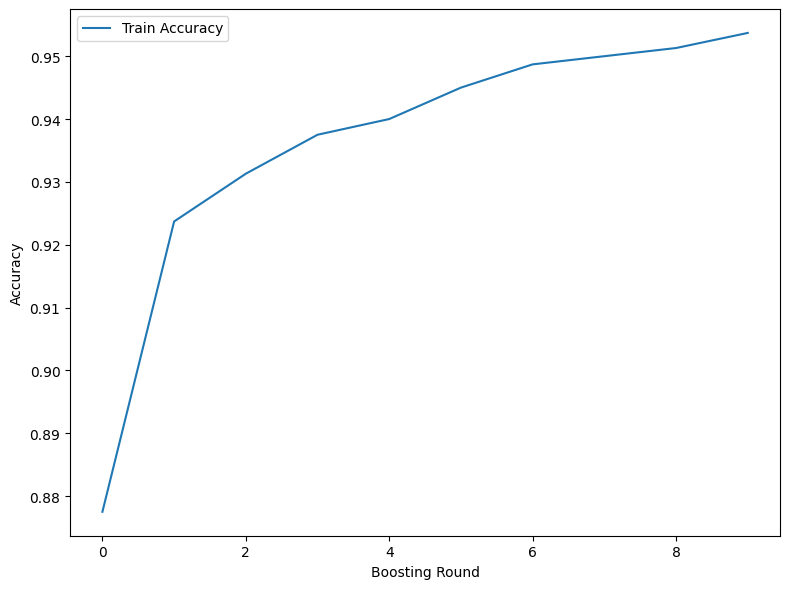

In [123]:
import matplotlib.pyplot as plt

def Accuracy_Graph(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Boosting Round')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

history = {
    'train_accuracy': [0.8775, 0.9237, 0.9313, 0.9375, 0.9400, 0.9450, 0.9487, 0.9500, 0.9513, 0.9537], 
}
Accuracy_Graph(history)
